# Introduction
Accurate classification of leukemia subtypes based on gene expression profiles plays a critical role in diagnosis, prognosis, and treatment selection. In this study, we investigate the use of Support Vector Machines (SVMs) for supervised classification of patients based on high-dimensional gene expression data. The dataset consists of 79 patient samples, each characterized by expression levels of 2,000 genes and labeled according to cytogenetic status: patients with a chromosomal translocation (labeled as 1) and cytogenetically normal patients (labeled as -1).

Given the high dimensionality and limited sample size, a common scenario in genomic studies, robust modeling and appropriate preprocessing are essential. The choice of SVMs is due to their well-established effectiveness in high-dimensional settings, leveraging their ability to construct optimal separating hyperplanes with strong generalization performance. This analysis aims to evaluate the capacity of SVMs to distinguish between these two leukemia subtypes and assess model performance through cross-validation and ROC-based metrics.

# Loading Data and Exploration on the Full Dataset

In [212]:
# Perform the necessary library imports
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay
from ISLP.svm import plot as plot_svm
import warnings

In [213]:
warnings.filterwarnings('ignore')

Given that the data is provided as a tab separated values, we specify the `sep` argument in the `read_csv` function from pandas to `\t` to make sure that the data is read correctly.

In [214]:
# load data
df = pd.read_csv('data/gene_data.tsv', sep='\t')

Additionally we check whether there are missing data in the dataset and confirm that the dataset is complete with a total of 79 rows and 2002 columns.

In [215]:
print(sum(df.isna().sum(axis=1)))
print(f'shape of the dataset {df.shape}')

0
shape of the dataset (79, 2002)


## Data Exploration
We can explore the data by lowering its dimensionality. This can be done by using Principal Component Analysis (PCA) which aims to identify the main sources of variation among a set of predictors and plot data based on those principal components. We first get our set of predictors and store them in a matrix (`X`) based on a `pandas.DataFrame` object. We also save the vector of target labels as a `pandas.Series` object to make it compatible with the framework provided by SciKit-Learn.

In [216]:
X = df.drop(['y', 'sampleID'], axis=1)
y = df['y']

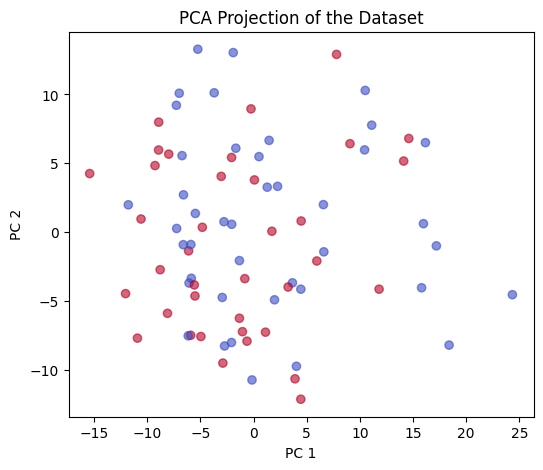

In [217]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA Projection of the Dataset")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

From this plot we can see that the classification problem cannot be easily described in terms of linearly separable classes and serves as a hint that SVMs with non-linear kernels might perform better for this specific task.

## Model selection

We start by splitting the data into train and test portions for future evaluations.

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

Then we start fitting different models and comparing them after they have been finetuned through 5-fold CV. Additionally, we scale the data to make sure all features' predictive power is evaluated correctly by the model.

### Linear SVC
For the simplest model, we have to tune the C (cost) hyperparameter. To this end we perform a 5-fold CV to find the better parameter among a series of values. To make the modeling easier and avoid repetitions, we use the convenient function `make_pipeline` from the `sklearn.pipeline` module. This function instantiates a series of steps that should be performed before the model is fit. Since scaling the data is beneficial when fitting models from the SVM family, by instantiating a specific pipeline we can avoid calling a scaling function every time.

In [219]:
svc_model = make_pipeline(StandardScaler(),
              SVC())
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [220]:
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    svc_model,
    {"svc__C": C_values,
     'svc__kernel': ['linear']},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [221]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'svc__kernel': ['linear']},
             scoring='accuracy')

In [222]:
best_linear_svm = grid.best_estimator_

In [223]:
preds = best_linear_svm.predict(X_test)
acc = (preds == y_test).mean()
print(f"accuracy of the SVC is {acc}")

accuracy of the SVC is 0.675


### Radial Kernel SVM
To account for the possibility of a non-linearly separable classification problem, we also fit an SVM with a Radial Kernel which allows for non-linear decision boundaries and could therefore provide a more flexible model to better tackle the classification task.

In [224]:
radial_svm_model = make_pipeline(StandardScaler(),
              SVC())
radial_svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [225]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.5, 1, 2, 3, 4]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    radial_svm_model,
    {"svc__C": C_values,
    "svc__kernel": ['rbf'],
     'svc__gamma': gamma_range},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [226]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'svc__gamma': [0.5, 1, 2, 3, 4],
                         'svc__kernel': ['rbf']},
             scoring='accuracy')

In [227]:
best_radial_svm_model = grid.best_estimator_

## Model comparison with ROC curves

In [228]:
roc_curve = RocCurveDisplay.from_estimator 

We first plot the ROC Curve for the linear model and notice how the performance on the test set are not surprisingly good, being only around 10% better than random guesses.

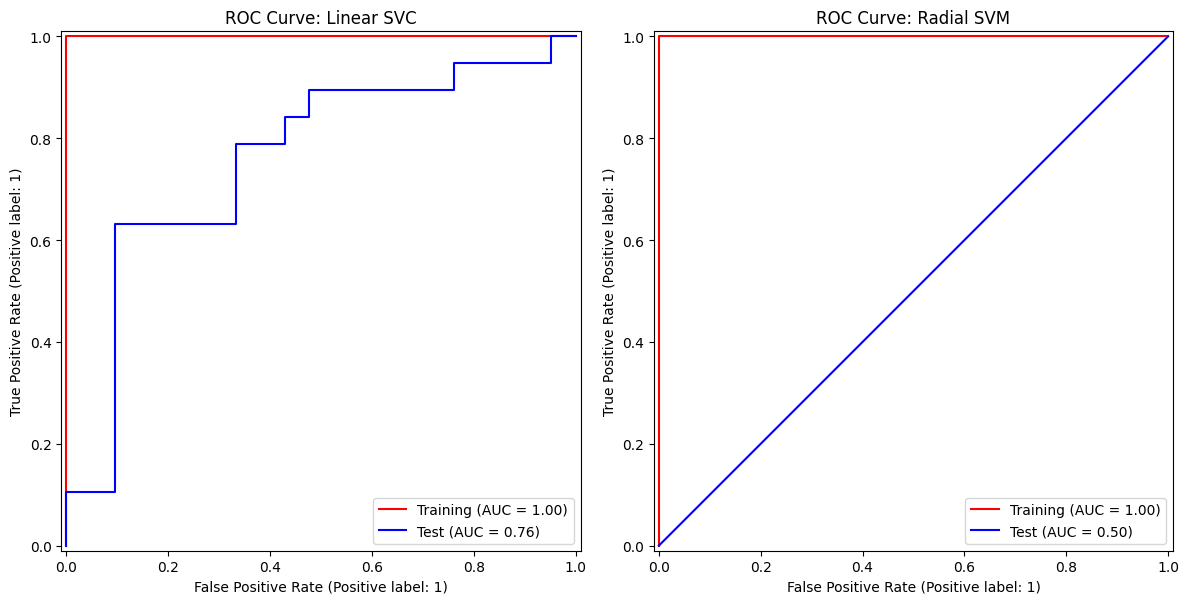

In [229]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# ROC for Linear SVM
RocCurveDisplay.from_estimator(best_linear_svm, X_train, y_train, name="Training", color="r", ax=axes[0])
RocCurveDisplay.from_estimator(best_linear_svm, X_test, y_test, name="Test", color="b", ax=axes[0])
axes[0].set_title('ROC Curve: Linear SVC')

# ROC for Radial SVM
RocCurveDisplay.from_estimator(best_radial_svm_model, X_train, y_train, name="Training", color="r", ax=axes[1])
RocCurveDisplay.from_estimator(best_radial_svm_model, X_test, y_test, name="Test", color="b", ax=axes[1])
axes[1].set_title('ROC Curve: Radial SVM')

plt.tight_layout()

In [230]:
preds = best_radial_svm_model.predict(X_test)
confusion_matrix(y_true=y_test, y_pred=preds)

array([[21,  0],
       [19,  0]])

For the radial kernel SVM we can easily see how the model is assigning all predictions to the positive class and thus misclassifying all negatively labeled observations.

# Fit on reduced feature set

We now select only the features (genes) that are in the top 5% in terms of variability. 

In [231]:
# Compute standard deviation of each gene (feature)
stds = X.std(axis=0)

# Determine threshold for the top 5% most variable genes
threshold = np.percentile(stds, 95)  # Top 5%

# Select features (genes) with std above the threshold
top_variable_genes = stds[stds > threshold].index

# Filter dataset to include only the selected genes
X_filtered = X[top_variable_genes]
print(f'number of predictors is {X_filtered.shape[1]}')

number of predictors is 100


We can see that now the number of predictors has reduced to 100 thus effectively reducing the noise associated to features that inherently added little to no information to the model. This also helps with reducing the dimensionality of the dataset and might therefore make the fit of SVM models better.

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.5, stratify=y,random_state=1)

In [233]:
svc_model = make_pipeline(StandardScaler(),
              SVC())
svc_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [234]:
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    svc_model,
    {"svc__C": C_values,
     'svc__kernel': ['linear']},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [235]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'svc__kernel': ['linear']},
             scoring='accuracy')

In [236]:
best_linear_svm = grid.best_estimator_

In [237]:
radial_svm_model = make_pipeline(StandardScaler(),
              SVC())
radial_svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [238]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.5, 1, 2, 3, 4]

kfold = KFold(5, random_state=0, shuffle=True)
grid = GridSearchCV(
    radial_svm_model,
    {"svc__C": C_values,
    'svc__kernel': ['rbf'],
     'svc__gamma': gamma_range},
    # double underscore to access directly the svc model in the pipeline
    refit=True,
    cv=kfold,
    scoring="accuracy",  # use accuracy as the reference metric (default)
)

In [239]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'svc__gamma': [0.5, 1, 2, 3, 4],
                         'svc__kernel': ['rbf']},
             scoring='accuracy')

In [240]:
best_radial_svm_model = grid.best_estimator_

## ROC Curves for models fitted on Reduced Dataset

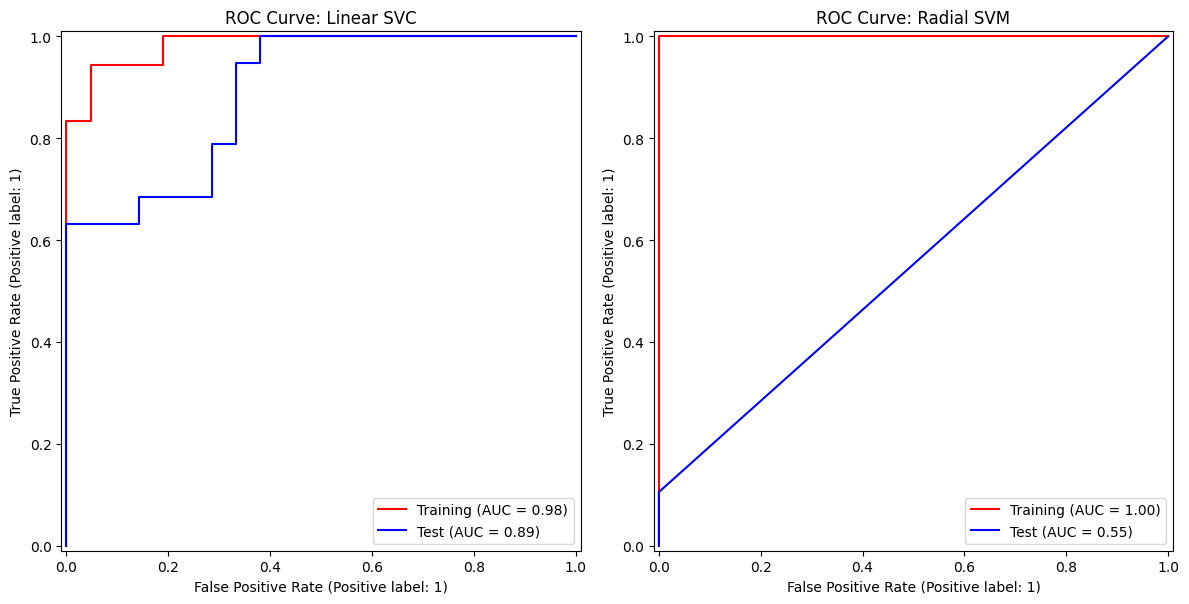

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# ROC for Linear SVM
RocCurveDisplay.from_estimator(best_linear_svm, X_train, y_train, name="Training", color="r", ax=axes[0])
RocCurveDisplay.from_estimator(best_linear_svm, X_test, y_test, name="Test", color="b", ax=axes[0])
axes[0].set_title('ROC Curve: Linear SVC')

# ROC for Radial SVM
RocCurveDisplay.from_estimator(best_radial_svm_model, X_train, y_train, name="Training", color="r", ax=axes[1])
RocCurveDisplay.from_estimator(best_radial_svm_model, X_test, y_test, name="Test", color="b", ax=axes[1])
axes[1].set_title('ROC Curve: Radial SVM')

plt.tight_layout()

In [242]:
preds_svc = best_linear_svm.predict(X_test)
acc = (preds_svc == y_test).mean()
print(f"The accuracy of the SVC is {acc}")

The accuracy of the SVC is 0.75


We can see that the performance from the radial kernel SVM did not improve by much compared to the full feature case. Indeed, also in this case the model is predicting all observations to belong to the same class and the AUC suggests that it is only marginally better than guessing a label.

In [243]:
preds = best_radial_svm_model.predict(X_test)
print(confusion_matrix(y_true=y_test, y_pred=preds))

[[21  0]
 [19  0]]


# Conclusion and Discussion
Based on the analyses conducted, several insights can be drawn regarding the performance and stability of Support Vector Machine (SVM) models in high-dimensional classification settings. While SVMs, particularly those employing non-linear kernels such as the radial basis function, are theoretically capable of mapping data into higher-dimensional spaces where class separation becomes more feasible, they are nonetheless susceptible to the effects of the curse of dimensionality. This phenomenon becomes evident when comparing the performance of a linear SVM trained on the full gene expression dataset to one trained only on a subset of the most variable genes.

In the initial scenario, where all 2,000 gene expression variables were retained, including many with low variability and potential noise, the linear SVM achieved an accuracy of approximately 55%, indicating poor generalization. However, after filtering the dataset to retain only the top 5% of genes with the highest standard deviation, the same model achieved a substantially higher accuracy of around 75%. This marked improvement highlights the importance of feature selection in high-dimensional biological data, where irrelevant or low-variance features may obscure true class boundaries and degrade classifier performance. These results make it clearer that while SVMs are powerful tools for classification, especially in genomics, their success is contingent on careful data preprocessing and dimensionality reduction strategies.

## Additional Materials
The full GitHub repository with the code necessary to replicate the analysis is available [here](https://github.com/tricarico672/SM_HW3)